# GA for Job Shop Scheduling Problem

### Prepare Data

In [4]:
%pip install -q numpy 
%pip install -q pandas
%pip install -q matplotlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
import numpy as np
import pandas as pd

# Parameter Definition
num_jobs = 10
num_machines = 10

# often 30
pop_size = 15

mutation_rate = 0.05
crossover_rate = 0.5
max_iteration_time = 400
num_elitism_survivors = int(pop_size / 3)
num_tournament_competitors = int(pop_size / 4/3)

processing_time = pd.read_csv("..\Dataset\Processing Time.csv")
machine_sequence = pd.read_csv("..\Dataset\Machine Sequence.csv")
priority_due_date = pd.read_csv("..\Dataset\Priority & Due Date.csv")

print("processing_time\n",processing_time.head(),"\n")
print("machine_seq\n",machine_sequence.head(),"\n")
print("Priority & Due Date\n",priority_due_date.head(),"\n")


processing_time
   Job  O1  O2  O3  O4  O5  O6  O7  O8  O9  O10
0  J1  29  78   9  36  49  11  62  56  44   21
1  J2  43  90  75  11  69  28  46  46  72   30
2  J3  91  85  39  74  90  10  12  89  45   33
3  J4  81  95  71  99   9  52  85  98  22   43
4  J5  14   6  22  61  26  69  21  49  72   53 

machine_seq
   Job  O1  O2  O3  O4  O5  O6  O7  O8  O9  O10
0  J1   1   2   3   4   5   6   7   8   9   10
1  J2   1   3   5  10   4   2   7   6   8    9
2  J3   2   1   4   3   9   6   8   7  10    5
3  J4   2   3   1   5   7   9   8   4  10    6
4  J5   3   1   2   6   4   5   9   8  10    7 

Priority & Due Date
   Job  Priority  Due date
0  J1        10       919
1  J2         5       785
2  J3         1       907
3  J4         5       849
4  J5        10       887 



<>:17: SyntaxWarning: invalid escape sequence '\D'
<>:18: SyntaxWarning: invalid escape sequence '\D'
<>:19: SyntaxWarning: invalid escape sequence '\D'
<>:17: SyntaxWarning: invalid escape sequence '\D'
<>:18: SyntaxWarning: invalid escape sequence '\D'
<>:19: SyntaxWarning: invalid escape sequence '\D'
C:\Users\okumo\AppData\Local\Temp\ipykernel_12968\2593691352.py:17: SyntaxWarning: invalid escape sequence '\D'
  processing_time = pd.read_csv("..\Dataset\Processing Time.csv")
C:\Users\okumo\AppData\Local\Temp\ipykernel_12968\2593691352.py:18: SyntaxWarning: invalid escape sequence '\D'
  machine_sequence = pd.read_csv("..\Dataset\Machine Sequence.csv")
C:\Users\okumo\AppData\Local\Temp\ipykernel_12968\2593691352.py:19: SyntaxWarning: invalid escape sequence '\D'
  priority_due_date = pd.read_csv("..\Dataset\Priority & Due Date.csv")


### Generate Initail Population (with defined encoding)

In [6]:
# if the order is [1, 2, 1, 3, 3, ...]
# meaning J1 first operation -> J2 first operation  -> J1 second operation......

def initialize_population(pop_size, num_jobs):
    # Create an array with numbers 1 to 10 repeated 10 times
    base_array = np.tile(np.arange(1, 11), num_jobs) 
    population = []
    for _ in range(pop_size):
        individual = np.random.permutation(base_array)
        population.append(individual)
    return population

### Evaluation (fitness score, crowding distance)

In [7]:
def evaluate_fitness_score(individual):
    
    # Ji shows how many times of operation have been down
    # Ji_end shows the time that last Ji ends
    job_calculator = {}
    for i in range(num_jobs):
        job_calculator[f"J{i+1}"] = 0
        job_calculator[f"J{i+1}_end"] = 0

    # machine time shows the time that last job ends
    machine_time = {f'M{i+1}': 0 for i in range(num_machines)}
    
    for job in individual:
        
        # shows the progess of each jobs
        job_name = f"J{job}"
        job_calculator[job_name]+=1
        current_operation = job_calculator[job_name]
        
        job_operation = machine_sequence[machine_sequence["Job"]==job_name]
        # Find the column with number of times of operation
        operation_name = job_operation.columns[job_operation[job_operation == current_operation].any()][0]
        operation_number = int(operation_name.split("O")[1])
                
        # check the time that operation takes
        duration = processing_time[processing_time["Job"]==job_name][f'O{operation_number}'].values[0]
        
        #  machine number = operation number
        machine_name = f"M{operation_number}"
        machine_time[machine_name] = max(machine_time[machine_name], job_calculator[f"{job_name}_end"])
        machine_time[machine_name] += duration
        job_calculator[f"{job_name}_end"] = machine_time[machine_name]
        
        # check code's correctness
        # print(f"job = {job_name}, times = {current_operation} ,operation = {operation_number}, time_spent = {duration}")
        
    # calcualte makespan & twet
    # print(f"j {job_calculator.values()}")
    # print(f"m {machine_time.values()}")
    
    makespan = 0
    for k,v in job_calculator.items():
        if k.endswith("end"):
            # print(f"d : {due_date} - end : {v}")
            makespan = max(makespan, v) 
            
    return makespan


### Selection Function

In [8]:
# Tournament method
def selection(populatoin_with_makespan, pop_size ,number_of_competitors):
    population = populatoin_with_makespan["population"]
    makespan = populatoin_with_makespan["makespan"]
    selected = []
    for _ in range(pop_size):
        # note: I decide to user random sample instead of permutation to increase diversity
        competitors = np.random.permutation(len(population))[:number_of_competitors]
        
        v = max(makespan[i] for i in competitors)
        for i in competitors:
            if makespan[i]==v:
                selected.append([population[i], makespan[i]])
                break
        
    return pd.DataFrame(selected,columns=["population", "makespan"])

### Crossover & Mutation

In [9]:
import random
from collections import Counter

# Davis’ Order Crossover(for Job Shop Scheduling)
def crossover(individual1, individual2):
    length = len(individual1)
    
    # Initialize the offspring with None values
    offspring1 = [None] * length
    offspring2 = [None] * length
    
    # Choose two crossover points
    cxpoint1, cxpoint2 = sorted(random.sample(range(length), 2))
    
    # Copy the sub-sequence from parent1 to offspring1 and parent2 to offspring2
    offspring1[cxpoint1:cxpoint2] = individual1[cxpoint1:cxpoint2]
    offspring2[cxpoint1:cxpoint2] = individual2[cxpoint1:cxpoint2]
    
    # Create a counter for each offspring
    counter1 = Counter(offspring1[cxpoint1:cxpoint2])
    counter2 = Counter(offspring2[cxpoint1:cxpoint2])
    
    def fill_offspring(parent, offspring, counter):
        current_pos = 0
        for gene in parent:
            if counter[gene] < 10:
                while offspring[current_pos] is not None:
                    current_pos = (current_pos + 1) % length
                offspring[current_pos] = gene
                counter[gene] += 1
    
    # Fill the rest of the genes in the offspring
    fill_offspring(individual2, offspring1, counter1)
    fill_offspring(individual1, offspring2, counter2)
    
    return [offspring1, offspring2]

# Change side if 
def mutate(individual):
    i, j = random.sample(range(len(individual)), 2)
    individual[i], individual[j] = individual[j], individual[i]
    return individual



### Elitsm Strategy

In [10]:
def elitism_strategy(population, number_of_survivors):
    sorted_df = population.sort_values(by=["makespan"], ascending=[True])
    survivors_df = sorted_df.head(number_of_survivors)
    return survivors_df

### Main Function

In [11]:
# NSGA-II Implementation
iteration = 0
unscored_population = []
population_list = []
line_graph_data = []
best_graph_data = []
selected_population = []
best_of_all = pd.DataFrame(columns=["population", "makespan"])
while(iteration <= max_iteration_time):
    
    if len(population_list) == 0 :
        population_list = initialize_population(pop_size,num_jobs)
    else:
        population_list = sorted_population["population"]
  
    for population in population_list:
        makespan= evaluate_fitness_score(population)
        unscored_population.append([population,makespan])

    selected_population = selection(pd.DataFrame(unscored_population,columns=["population", "makespan"]),pop_size ,num_tournament_competitors)

    # crossover & mutation 
    size = len(selected_population)
    for i in range(size):
        if random.random() < crossover_rate:
            random_pick_index = random.randrange(0, size)
            offsprings =crossover(selected_population["population"].iloc[i], selected_population["population"].iloc[random_pick_index])
            for offspring in offsprings:
                mkspn= evaluate_fitness_score(offspring)
                new_row = pd.DataFrame({
                    'population': [offspring],
                    'makespan': mkspn,
                })
                selected_population = pd.concat([selected_population,new_row],ignore_index=True)
            
        if random.random() < mutation_rate: 
            offspring = mutate(selected_population["population"].iloc[i])
            mkspn= evaluate_fitness_score(offspring)
            new_row = pd.DataFrame({
                    'population': [offspring],
                    'makespan': mkspn,
                })
            selected_population = pd.concat([selected_population,new_row],ignore_index=True)
    
    print(f"interation: {iteration}")
    iteration+=1
    print(f"current population size: {len(selected_population)}")
    
    # sort by makespan (ascending)
    sorted_population = elitism_strategy(pd.DataFrame(selected_population), num_elitism_survivors)
    
    # show the current best result of all
    top_ranked_df = pd.DataFrame(sorted_population.head(1))
    if (best_of_all.shape[0] == 0) or (top_ranked_df['makespan'].values < best_of_all['makespan'].values):
        best_of_all = top_ranked_df
    
    line_graph_data.append(top_ranked_df['makespan'].values[0])
    best_graph_data.append(best_of_all['makespan'].values[0])
    print(f"makespan: {top_ranked_df['makespan'].values[0]}")
    print(f"BEST makespan: {best_of_all['makespan'].values[0]}\n")
    
    

interation: 0
current population size: 27
makespan: 1623
BEST makespan: 1623

interation: 1
current population size: 33
makespan: 1562
BEST makespan: 1562

interation: 2
current population size: 34
makespan: 1581
BEST makespan: 1562

interation: 3
current population size: 27
makespan: 1562
BEST makespan: 1562



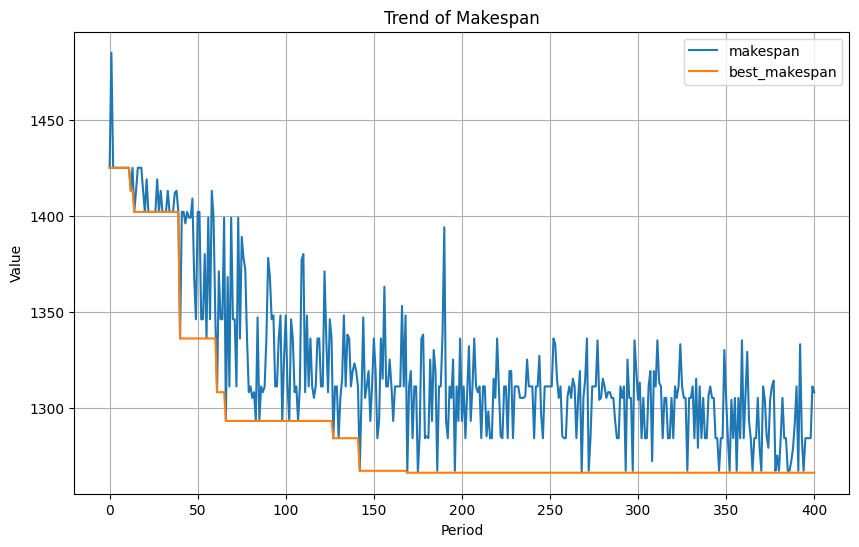

In [ ]:

import matplotlib.pyplot as plt

makespan_data = line_graph_data
best_makespan_data = best_graph_data

x_axis = range(len(line_graph_data))

plt.figure(figsize=(10, 6))
plt.plot(x_axis, makespan_data, label='makespan')
plt.plot(x_axis, best_makespan_data, label='best_makespan')
plt.xlabel('Period')
plt.ylabel('Value')
plt.title('Trend of Makespan')
plt.legend()
plt.grid(True)
plt.show()

## Questions

1. In what scenario we use GA ?
> ans: any time when you have good encoding form
2. How to define a Good solution in meta heuristic algo ?
> ans: try a smaller problem see if it can get optimal sloution(find by gurobi). how close is it? 
3. Exploration and Expoitation handling ? e.g. mutaion rate need to be dynamic? Explration fisrt (overview the whole solution space) 
> ans: Although they both are really important but the most important part is still encoding
